In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root = '/home/huyen/data/cifar10', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = '/home/huyen/data/cifar10', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


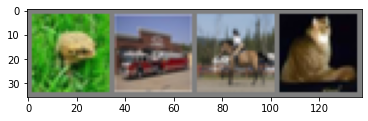

 frog truck horse   cat


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#get some random training images
detaite = iter(trainloader)
images, labels = detaite.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))


# Define a convolution neural network

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Define loss function and optimizer

In [16]:
import torch.optim as optim

criteration = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## Train the net work

In [18]:
for epoch in range(2):
    runing_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()

        output = net(inputs)
        loss = criteration(output, labels)
        loss.backward()
        optimizer.step()

        runing_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f'%(epoch+1, i+1, runing_loss/2000))
            runing_loss = 0.0
print('finish training')

[1,  2000] loss: 2.234
[1,  4000] loss: 1.910
[1,  6000] loss: 1.734
[1,  8000] loss: 1.604
[1, 10000] loss: 1.523
[1, 12000] loss: 1.477
[2,  2000] loss: 1.408
[2,  4000] loss: 1.363
[2,  6000] loss: 1.336
[2,  8000] loss: 1.335
[2, 10000] loss: 1.299
[2, 12000] loss: 1.300
finish training


In [19]:
PATH = '/home/huyen/model/cifar-10.net'
torch.save(net.state_dict(), PATH)

## Test the network on the test data

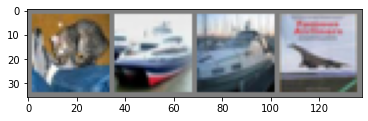

GroundTruth:    cat  ship  ship plane


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s'%classes[labels[j]] for j in range(4)))


In [23]:
net = Net()
net.load_state_dict(torch.load(PATH))

output = net(images)

_, predicted = torch.max(output, 1)
print('Predicted: ',' '.join('%5s' %classes[predicted[i]] for i in range(4)))

Predicted:    cat  ship  ship  ship


## How network perform on the whole dataset


In [24]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct+=(predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%'%(100*correct/total))


Accuracy of the network on the 10000 test images: 54 %


## performence on each class

In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label]+= c[i].item()
            class_total[label] +=1
for i in range(10):
    print('Accuracy of %5s : %2d %%'%(classes[i], 100*class_correct[i]/class_total[i]))
    

Accuracy of plane : 62 %
Accuracy of   car : 66 %
Accuracy of  bird : 49 %
Accuracy of   cat : 25 %
Accuracy of  deer : 36 %
Accuracy of   dog : 44 %
Accuracy of  frog : 75 %
Accuracy of horse : 48 %
Accuracy of  ship : 64 %
Accuracy of truck : 70 %


## Training on GPU

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu
